Conjugate Gradient converged at iteration 43
Conjugate Gradient converged at iteration 43
Conjugate Gradient time: 0.0011 seconds
GMRES time: 0.0075 seconds


/tmp/ipykernel_827172/2908628086.py:44: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  xexact = spsolve(B, b)
/tmp/ipykernel_827172/2908628086.py:59: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  xk_final, exitCode = gmres(B, b, tol=tol, callback=callback, callback_type='x')


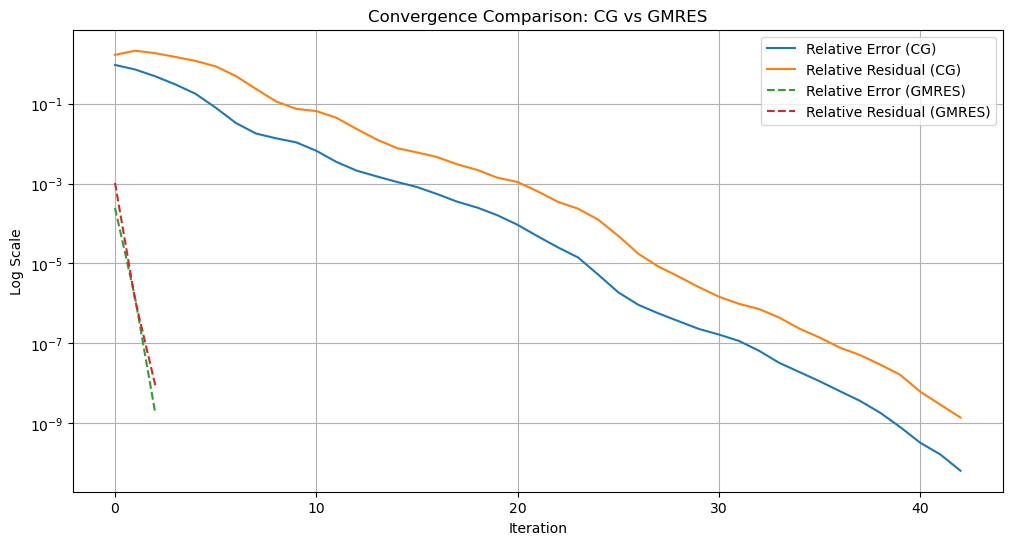

In [5]:
import numpy as np
import scipy.sparse as spsp
from scipy.sparse.linalg import spsolve, gmres
import time
import matplotlib.pyplot as plt

def gradient_conjugue(A, b, xexact, max_iter=1000, tol=1e-8):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    d = r.copy()
    errors = []
    residuals = []
    r_norm = np.dot(r, r)
    initial_r_norm = r_norm

    for k in range(max_iter):
        Ad = A @ d
        alpha = r_norm / np.dot(d, Ad)
        x = x + alpha * d
        r = r - alpha * Ad
        new_r_norm = np.dot(r, r)
        # 计算误差和残差
        error = np.linalg.norm(xexact - x) / np.linalg.norm(xexact)
        residual = np.sqrt(new_r_norm / initial_r_norm)
        errors.append(error)
        residuals.append(residual)
        # 检查收敛
        if np.sqrt(new_r_norm) < tol:
            print(f"Conjugate Gradient converged at iteration {k+1}")
            break
        beta = new_r_norm / r_norm
        d = r + beta * d
        r_norm = new_r_norm
    return x, errors, residuals

# 构建稀疏矩阵 B
d = 10  # 可以根据需要调整矩阵大小
n = d ** 2
B = spsp.diags([[4.]*n, [-1]*(n-1), [-1]*(n-1), [-1]*(n-d), [-1]*(n-d)], [0, 1, -1, d, -d])

# 生成右端项和精确解
b = np.random.rand(n)
xexact = spsolve(B, b)

# 运行共轭梯度算法
x_cg, errors_cg, residuals_cg = gradient_conjugue(B, b, xexact, max_iter=1000, tol=1e-8)

# 定义一个函数来记录时间并运行 GMRES
def run_gmres(B, b, xexact, tol=1e-8):
    start_time = time.time()
    callback_info = {'residuals': [], 'errors': []}
    def callback(xk):
        error = np.linalg.norm(xexact - xk) / np.linalg.norm(xexact)
        rk = b - B @ xk
        residual = np.linalg.norm(rk) / np.linalg.norm(b)
        callback_info['errors'].append(error)
        callback_info['residuals'].append(residual)
    xk_final, exitCode = gmres(B, b, tol=tol, callback=callback, callback_type='x')
    end_time = time.time()
    return xk_final, callback_info['errors'], callback_info['residuals'], end_time - start_time

# 运行 GMRES 算法
x_gmres, errors_gmres, residuals_gmres, time_gmres = run_gmres(B, b, xexact)

# 运行时间比较
start_time_cg = time.time()
x_cg, errors_cg, residuals_cg = gradient_conjugue(B, b, xexact, max_iter=1000, tol=1e-8)
end_time_cg = time.time()
time_cg = end_time_cg - start_time_cg

print(f"Conjugate Gradient time: {time_cg:.4f} seconds")
print(f"GMRES time: {time_gmres:.4f} seconds")

# 绘制比较图
plt.figure(figsize=(12,6))
plt.semilogy(errors_cg, label='Relative Error (CG)')
plt.semilogy(residuals_cg, label='Relative Residual (CG)')
plt.semilogy(errors_gmres, label='Relative Error (GMRES)', linestyle='--')
plt.semilogy(residuals_gmres, label='Relative Residual (GMRES)', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Convergence Comparison: CG vs GMRES')
plt.legend()
plt.grid(True)
plt.show()
